# Imports and constants

In [5]:
%load_ext autoreload
%autoreload 2

In [6]:
import sys
sys.path.append("..")
from src.utils import *

In [7]:
import pandas as pd
import seaborn as sns
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm
import os
from scipy import ndimage
from scipy.spatial import distance
from sklearn.cluster import KMeans
from bunch import Bunch
from sklearn.model_selection import train_test_split

In [8]:
# DATASET_PATH = NIEMCZYK_DATASET_PATH
DATASET_PATH = MARCINIAK_DATASET_PATH

# Labels preparation

In [9]:
def coins_with_no_grade(df):
    df = df[df["title_state"].isna() & df["description_state"].isna()]
    return df 

def coins_with_ambiguity(df):
    df = df[df["title_state"].str.replace(" ","") != df["description_state"].str.replace(" ","")]
    df = df[df["title_state"].notna() & df["description_state"].notna()]
    return df

def unify_states(df):
    df = df[~df.index.isin(coins_with_no_grade(df).index)]
    df = df[~df.index.isin(coins_with_ambiguity(df).index)]
    df["state"] = df["title_state"]
    df.loc[df["state"].isna(), "state"] = df["description_state"]
    df.drop(["description_state", "title_state"], axis=1, inplace = True)
    return df

def find_nearest(array, value):
    array = np.asarray(array)
    idx = (np.abs(array - value)).argmin()
    return array[idx]

def get_nearest_category_value(grade, categories=["1", "2", "3"]):
    basic_grading_dict_inv = {v: k for k, v in basic_grading_dict.items()}
    categories_in_sheldon = [basic_grading_dict[cat] for cat in categories]
    nearest_sheldon_value = find_nearest(categories_in_sheldon, grade)
    return basic_grading_dict_inv[nearest_sheldon_value]

def calculate_sheldon_and_categories(df, categories=["1","1-","2","2-","3"]):
    df = unify_states(df)
    df["sheldon"] = df["state"].apply(get_shaldon_value)
    df["category"] = df["sheldon"].apply(lambda grade: get_nearest_category_value(grade, categories))
    return df

,date,description,images,link,title,state,sheldon,category
0,"12 czerwca, 10:00",Opis pozycji\Stan zachowania: 2\Literatura: Ch...,['https://img1.onebid.pl/img/1482/433119_1b.jp...,https://aukcje.gndm.pl/pl/auction/1482/id/8146...,Sztandar 5 złotych 1930,2,52.0,2
1,06 lutego 2021,Opis pozycji\Stan zachowania: 2\Literatura: Ch...,['https://img1.onebid.pl/img/1236/386388_1b.jp...,https://aukcje.gndm.pl/pl/auction/1236/lot/333...,Sztandar 5 złotych 1930 - GŁĘBOKI,2,52.0,2
2,06 lutego 2021,Opis pozycji\Stan zachowania: 1-\Literatura: C...,['https://img1.onebid.pl/img/1236/330188_1b.jp...,https://aukcje.gndm.pl/pl/auction/1236/lot/333...,Sztandar 5 złotych 1930,1-,61.0,1-
3,03 października 2020,Opis pozycji\Stan zachowania: NGC UNC\Literatu...,['https://img1.onebid.pl/img/996/261269_1b.jpg...,https://aukcje.gndm.pl/pl/auction/996/lot/3336...,Sztandar 5 złotych 1930,NGC UNC,70.0,1
4,03 października 2020,Opis pozycji\Stan zachowania: 2\Literatura: Ch...,['https://img1.onebid.pl/img/996/287431_1b.jpg...,https://aukcje.gndm.pl/pl/auction/996/lot/3337...,Sztandar 5 złotych 1930,2,52.0,2
...,...,...,...,...,...,...,...,...
157,"08 marca 2010, 21:42",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429009701...,https://aukcje.gndm.pl/pl/auction/1000066/id/5...,"4254. 5 zł 1930 Sztandar, NGC AU details",NGC AU,52.0,2
158,"16 lutego 2010, 13:00",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429009599...,https://aukcje.gndm.pl/pl/auction/1000066/id/5...,"1019. 5 zł 1930 Sztandar, st.3",3,35.0,3
159,"12 grudnia 2009, 21:36",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429010378...,https://aukcje.gndm.pl/pl/auction/1000066/id/5...,"1565. 5 zł 1930 Sztandar, st.3+",3+,42.0,2-
160,"17 grudnia 2008, 21:45",Opis pozycji\Estymacje: 0 EUR | 1 PLN\\\Nr poz...,['https://img1.onebid.pl/img/1000066/429009072...,https://aukcje.gndm.pl/pl/auction/1000066/id/5...,"3545. 5 zł 1930, Sztandar - NGC AU 55",NGC AU 55,55.0,2


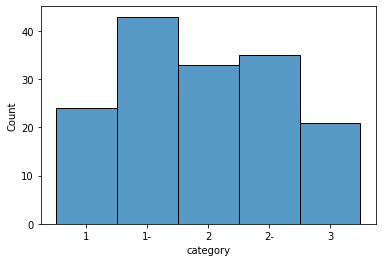

In [8]:
df = pd.read_csv(metadata_path(DATASET_PATH), sep='|')
df = calculate_sheldon_and_categories(df)
sns.histplot(df['category'].sort_values(), discrete=True )
df

# BoVW

In [10]:
def get_wear_marks(coin, design_mask):
    coin = cv2.cvtColor(coin, cv2.COLOR_BGR2GRAY)
    coin = cv2.resize(coin, (700,700))
    # coin = cv2.GaussianBlur(coin, (3,3), 0.5)
    # coin = cv2.Canny(coin, 0.6*255, 0.8*255)
    # coin = np.multiply(~design_mask.astype(bool), coin)
    return coin


def get_design_mask(master_coin):
    mask = master_coin.copy()
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2GRAY)
    mask = cv2.Canny(mask, 0.1*255, 0.2*255)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_CLOSE, kernel)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (4,4))
    mask = cv2.dilate(mask, kernel ,iterations = 1)

    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (3,3))
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, kernel)
    
    return mask

def get_wear_marks_dataset(dataset_path):
    master_coin_dict = { \
        1: cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/1.jpg"), \
        2: cv2.imread(master_coins_path(MARCINIAK_DATASET_PATH) + "/2.jpg"), \
    }
    design_mask_dict = { \
        1: get_design_mask(master_coin_dict[1]), \
        2: get_design_mask(master_coin_dict[2]), \
    }

    wear_marks_dataset = Bunch(X=[], y=[])

    metadata_df = pd.read_csv(metadata_path(dataset_path), sep="|")
    metadata_df = calculate_sheldon_and_categories(metadata_df, ["1", "2", "3"])
    side_df = pd.read_csv(side_path(dataset_path)).set_index("name")
    names = os.listdir(aligned_coins_path(dataset_path))
    names = [n for n in names if n.split(".")[-1] == "jpg"]

    for name in names:
        side = int(side_df.loc[name, "label"])
        index = int(name.split("_")[0])
        try:
            label = int(metadata_df.loc[index, "category"])
        
        # no label for the image
        except:
            continue
        im = cv2.imread("{}/{}".format(aligned_coins_path(dataset_path), name))
        wear_marks = get_wear_marks(im, design_mask_dict[side])
        wear_marks_dataset.X.append(wear_marks)
        wear_marks_dataset.y.append(label)
        
    return wear_marks_dataset

In [11]:
%%time

wmds_1 = get_wear_marks_dataset(MARCINIAK_DATASET_PATH)
wmds_2 = get_wear_marks_dataset(NIEMCZYK_DATASET_PATH)

wear_marks_dataset = Bunch(X=wmds_1.X + wmds_2.X, \
                           y=wmds_1.y + wmds_2.y)

CPU times: user 28.7 s, sys: 2.73 s, total: 31.4 s
Wall time: 41.1 s


In [12]:
def sift_features(X, y):
    pbar = tqdm(total=len(X))
    sift_vectors = {cat: [] for cat in np.unique(y)}
    descriptor_list = []
    sift = cv2.SIFT_create()
    for im, label in zip(X, y):
        kp, des = sift.detectAndCompute(im, None)
        descriptor_list.extend(des)
        sift_vectors[label].append(des)
        pbar.update(1)
    pbar.close()
    return [descriptor_list, sift_vectors]

def kmeans(k, descriptor_list):
    kmeans = KMeans(n_clusters = k, n_init=10)
    kmeans.fit(descriptor_list)
    visual_words = kmeans.cluster_centers_ 
    return visual_words


# Find the index of the closest central point to the each sift descriptor. 
# Takes 2 parameters the first one is a sift descriptor and the second one is the array of central points in k means
# Returns the index of the closest central point.  
def find_index(image, center):
    count = 0
    ind = 0
    for i in range(len(center)):
        if(i == 0):
           count = distance.euclidean(image, center[i])
        else:
            dist = distance.euclidean(image, center[i])
            if(dist < count):
                ind = i
                count = dist
    return ind

# Takes 2 parameters. The first one is a dictionary that holds the descriptors that are separated class by class 
# And the second parameter is an array that holds the central points (visual words) of the k means clustering
# Returns a dictionary that holds the histograms for each images that are separated class by class. 
def image_class(all_bovw, centers):
    dict_feature = {}
    for key,value in all_bovw.items():
        category = []
        for img in value:
            histogram = np.zeros(len(centers))
            for each_feature in img:
                ind = find_index(each_feature, centers)
                histogram[ind] += 1
            category.append(histogram)
        dict_feature[key] = category
    return dict_feature

# 1-NN algorithm. We use this for predict the class of test images.
# Takes 2 parameters. images is the feature vectors of train images and tests is the feature vectors of test images
# Returns an array that holds number of test images, number of correctly predicted images and records of class based images respectively
def knn(images, tests):
    num_test = 0
    correct_predict = 0
    class_based = {}
    
    for test_key, test_val in tests.items():
        class_based[test_key] = [0, 0] # [correct, all]
        for tst in test_val:
            predict_start = 0
            #print(test_key)
            minimum = 0
            key = "a" #predicted
            for train_key, train_val in images.items():
                for train in train_val:
                    if(predict_start == 0):
                        minimum = distance.euclidean(tst, train)
                        #minimum = L1_dist(tst,train)
                        key = train_key
                        predict_start += 1
                    else:
                        dist = distance.euclidean(tst, train)
                        #dist = L1_dist(tst,train)
                        if(dist < minimum):
                            minimum = dist
                            key = train_key
            
            if(test_key == key):
                correct_predict += 1
                class_based[test_key][0] += 1
            num_test += 1
            class_based[test_key][1] += 1
            #print(minimum)
    return [num_test, correct_predict, class_based]
    

In [13]:
[X_train, X_test, y_train, y_test] = train_test_split(wear_marks_dataset.X, wear_marks_dataset.y, test_size=0.3, random_state=42)

[train_descriptor_list, train_sift_vectors] = sift_features(X_train, y_train)
[test_descriptor_list, test_sift_vectors] = sift_features(X_test, y_test)

  0%|          | 0/809 [00:00<?, ?it/s]

  0%|          | 0/347 [00:00<?, ?it/s]

In [14]:
%%time

# Takes the central points which is visual words 
visual_words = kmeans(5, train_descriptor_list) 

In [ ]:
len(train_descriptor_list)

In [ ]:
%%time

# Creates histograms for train data    
bovw_train = image_class(train_sift_vectors, visual_words) 
# Creates histograms for test data
bovw_test = image_class(test_sift_vectors, visual_words) 

In [ ]:
%%time

# Call the knn function    
results_bowl = knn(bovw_train, bovw_test) 

In [ ]:
# Calculates the average accuracy and class based accuracies.  
def accuracy(results):
    avg_accuracy = (results[1] / results[0]) * 100
    print("Average accuracy: %" + str(avg_accuracy))
    print("\nClass based accuracies: \n")
    for key,value in results[2].items():
        acc = (value[0] / value[1]) * 100
        print('{} : % {}'.format(key, str(acc)))
        
# Calculates the accuracies and write the results to the console.       
accuracy(results_bowl) 